# Cartopy tutorial: Transforming raster to vector

The most common raster to vector transformation is contouring. In addition to that though, there are a number of image processing techniques for identifying features of interest.


### Contouring
Let's start with contouring:

<IPython.core.display.Javascript object>


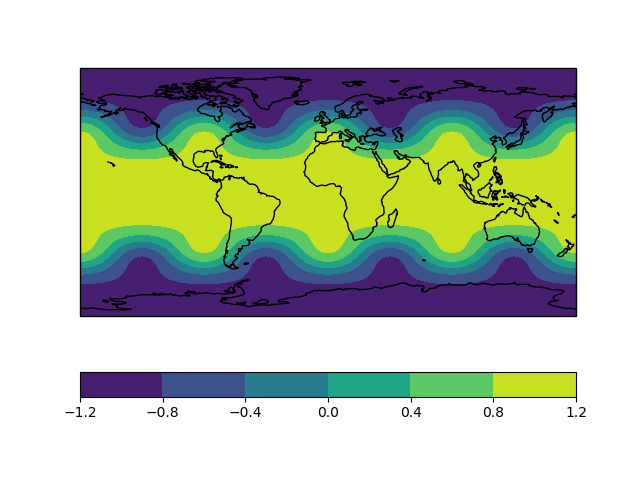

In [171]:
import cartopy.crs as ccrs
from cartopy.examples.waves import sample_data
import matplotlib.pyplot as plt

lons, lats, data = sample_data()

ax = plt.axes(projection=ccrs.PlateCarree())
cs = plt.contourf(
    lons, lats, data, 5,
    transform=ccrs.PlateCarree())
ax.coastlines()
plt.colorbar(orientation='horizontal')
plt.show()

Let's pick out one of these contours. We could choose to pick out a line (``contour``) or a polygon (``contourf``).
Since we have already produced filled contours, let's use those:

In [2]:
print(cs.levels)
print('N levels: {}'.format(len(cs.levels)))
print('N collections: {}'.format(len(cs.collections)))

[-1.2 -0.8 -0.4  0.   0.4  0.8  1.2]
N levels: 7
N collections: 6


In [172]:
print(cs.levels[4:6])
print(cs.collections[4])
paths = cs.collections[4].get_paths()

[0.4 0.8]


We now need to convert these matplotlib Paths into Shapely geometries. The [``descartes``](https://pypi.org/project/descartes/) is designed to do precisely this, but cartopy also has such functionality that has been tuned for performance:

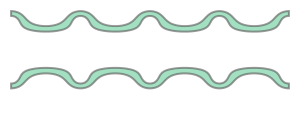

In [4]:
from cartopy.mpl.patch import path_to_geos
import shapely.ops

# Produces a list of shapely geometries.
geoms = []
for path in paths:
    geoms.extend(path_to_geos(path))

# Flatten the whole thing down to a single MultiPolygon
polygon = shapely.ops.unary_union(geoms)
polygon

We could use this geometry for any number of vector-type operations, but for now, let's just save it to disk. GeoJSON is a good choice for this kind of geometry - GeoJSON has become ubiquitous on the internet for its simpliciy and its interoperability with a number of popular tools/frameworks (including GitHub).

In [5]:
import json
import shapely.geometry as sgeom

with open('contour.geojson', 'w') as fh:
    json.dump(sgeom.mapping(polygon), fh)

We've uploaded this geojson to a GitHub gist to show how GitHub renders this file: https://gist.github.com/pelson/837ca8c01d38157a2d634dcf97260e45

Be aware that the GeoJSON specification states that geometries MUST be saved in WGS84. In this case, we are already in WGS84, but if we needed to we could project the geometry to the default ``ccrs.PlateCarree()`` projection with ``ccrs.PlateCarree().project_geometry(geometry, source_crs)``.

### Data space vs pixel space

So far we have used ``matplotlib.contour[f]`` to produce our contours, which conveniently returns contours in *data* coordinates. Sometimes we want to use tools that don't work in coordinate space, and which simply return pixel locations.

One of the most basic examples of this is numpy's ``where`` function. Let's use that to identify the yellow sections from the Wikipedia image below:

![Wikipedia route around the world](../../resources/640px-Around_the_World_in_Eighty_Days_map.png)

In [160]:
import numpy as np
import skimage.io

# Image has shape: (y: 296, x: 640, RGBA: 4)
atw80d = skimage.io.imread(
    '../../resources/640px-Around_the_World_in_Eighty_Days_map.png')

yellowish = ((atw80d[:, :, 0] > 200) &  # Lots of Red.
             (atw80d[:, :, 1] > 200) &  # Lots of Green.
             (atw80d[:, :, 2] < 100) &  # Not lots of Blue.
             (atw80d[:, :, 3] > 250))   # Not transparent.

ind_y, ind_x = np.where(yellowish)
print('Number of yellow-ish pixels: ', len(ind_x))
print('x indexes: ', ind_x)
print('y indexes: ', ind_y)

Number of yellow-ish pixels:  17
x indexes:  [ 85  86  79  80  81  82  83  84  85  86  79  80  81  82  83 421 422]
y indexes:  [ 82  82  83  83  83  83  83  83  83  83  84  84  84  84  84 116 116]


Conversion between pixel locations and data locations is currently quite manual, but the following function will allow us to go from pixel centers to data coordinates:

In [169]:
def pixels_to_data(extent, shape, i, j):
    """Converts from coordinates of the array to data coordinates."""
    xmin, xmax, ymin, ymax = extent
    x_range = xmax - xmin
    y_range = ymax - ymin
    
    pix_width = x_range / shape[1]
    pix_height = y_range / shape[0]

    # For y handle the fact that the image's pixels
    # start at the top (in mpl that is what origin='upper' means).
    j = shape[0] - j

    return (xmin + pix_width * (i + 0.5),
            ymin + pix_height * (j + 0.5))

If we feed in the image extent and the x and y indices computed using ``np.where``, we get the pixel location in the coordinate system of the image (Robinson):

In [170]:
# Use the extents computed in an earlier exercise.
extent = [-13639040, 17156514, -6321250, 8621343]

# Note: Data coords in Robinson.
xs, ys = pixels_to_data(
    extent, atw80d.shape,
    ind_x, ind_y)

print('Last 3 x coordinates (Robinson): ', xs[-3:])
print('Last 3 y coordinates (Robinson): ', ys[-3:])

Last 3 x coordinates (Robinson):  [-9621182.5640625  6642719.3921875  6690837.4453125]
Last 3 y coordinates (Robinson):  [4406118.28547297 2790702.82601351 2790702.82601351]


Now that we have the coordinates, let's plot the pixels we have identified:

<IPython.core.display.Javascript object>


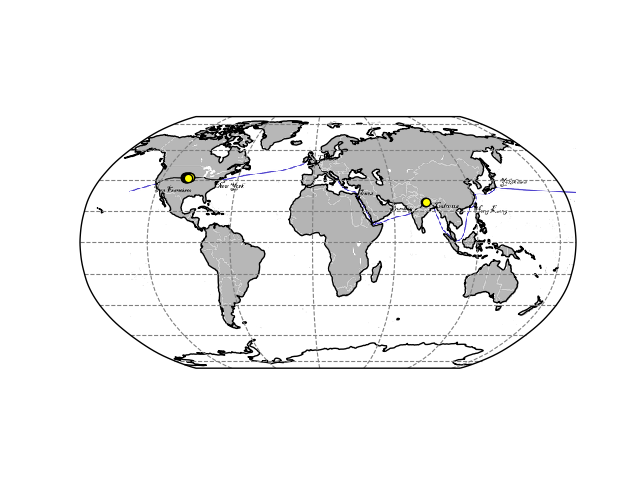

In [166]:
%matplotlib notebook
plt.figure()

rob = ccrs.Robinson(central_longitude=11.25)
ax = plt.axes(projection=rob)

ax.gridlines(color='gray', linestyle='--')
ax.coastlines()
ax.imshow(atw80d, extent=extent,
          transform=rob, origin='upper')
ax.set_global()

plt.plot(xs, ys, transform=rob,
         linestyle='none', marker='o',
         markeredgecolor='k', color='yellow')
plt.show()

<IPython.core.display.Javascript object>


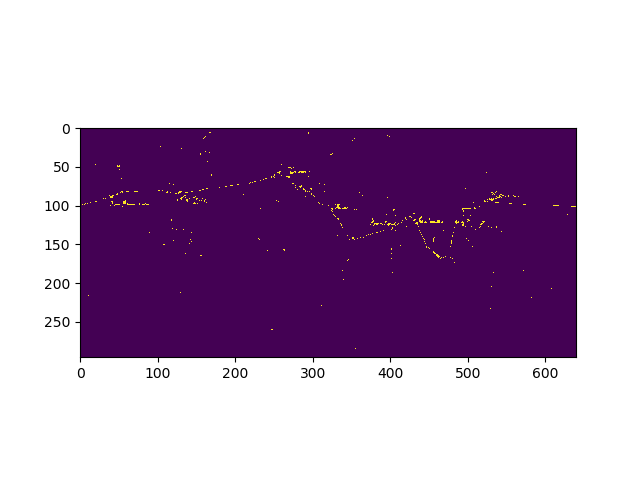

In [258]:
from skimage.filters import roberts, sobel, scharr, prewitt


# image = camera()
# edge_roberts = roberts(image)


full_color = atw80d.copy()


# im2[np.abs(im2 - v) < 0.05] = 1
# full_color[:, :, 3][(np.abs(full_color[:, :, 0:3] - 218) < 100).all(axis=-1)] = 255


no_land = atw80d[..., 0:2] == 183
land = no_land.all(axis=-1)

im2 = skimage.color.rgb2gray(full_color)
im2[full_color[:, :, 3] != 255] = 1
# im2[(np.abs(full_color[:, :, 0:3] - 218) < 200).all(axis=-1)] = 1

# im2[land] = 1
v = 183. / 255
im2[np.abs(im2 - v) < 0.05] = 1

# v = 218. / 255
# im2[np.abs(im2 - v) < 0.05] = 1
# im2[(np.abs(full_color[:, :, 0:3] - 216) < 10).all(axis=-1)] = 1



from skimage.color.adapt_rgb import adapt_rgb, each_channel, hsv_value
from skimage import filters


@adapt_rgb(each_channel)
def sobel_each(image):
    return filters.sobel(image)



# edge_sobel = sobel(im2)
# edge_sobel = sobel_each(atw80d)
# im2 = edge_sobel

import skimage.feature

# im2 = thin(1 - im2)

# edges2 = skimage.feature.canny(im2, sigma=2)
# im2 = edges2



plt.figure()
from skimage.morphology import skeletonize, medial_axis, thin

sk = im2
sk = skeletonize(medial_axis(1-im2))

sk, dist = medial_axis(1-im2, return_distance=True)
# sk = thin(1 - sk)

plt.imshow(dist > 1)

<IPython.core.display.Javascript object>


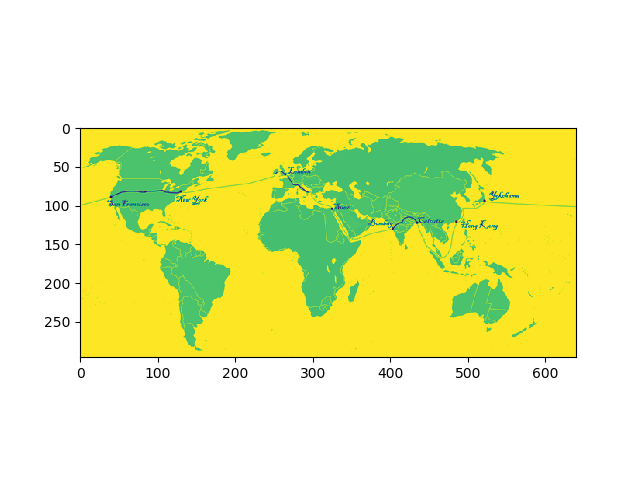

In [244]:
plt.figure()
plt.imshow(atw80d[:, :, 2])
plt.show()

<IPython.core.display.Javascript object>


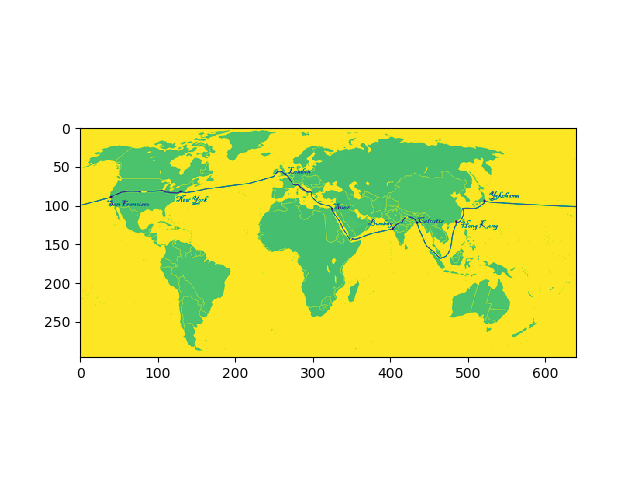

In [243]:
plt.figure()
plt.imshow(atw80d[:, :, 1])
plt.show()

<IPython.core.display.Javascript object>


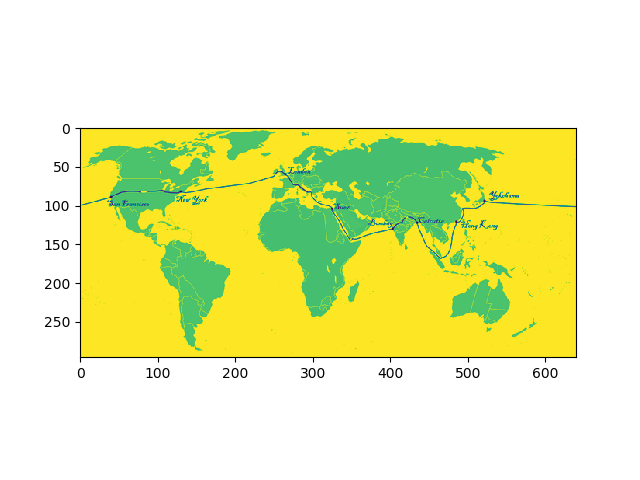

In [242]:
plt.figure()
plt.imshow(atw80d[:, :, 0])
plt.show()

<IPython.core.display.Javascript object>


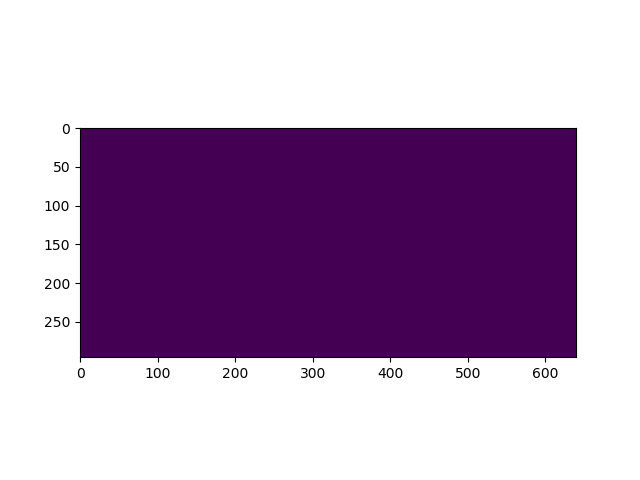

In [246]:
plt.figure()
plt.imshow(atw80d[:, :, 3])
plt.show()

In [ ]:
import skimage.feature
import skimage.color
import skimage.io

atw80d = skimage.io.imread(
    '../../resources/640px-Around_the_World_in_Eighty_Days_map.png')

features = skimage.feature.blob_doh(
    skimage.color.rgb2gray(atw80d),
    min_sigma=5)
features

### Skeletonization

Exercise: Extract contours from a raster, save to GeoJSON.

*Exercise:* Pull out the route from the wikipedia image.

*Exercise:* Project the geometry to PC, so that we can save it to GeoJSON.